# Anti-Hater Filter for Social Network

The aim of this project is to develop a multilabel classifier model capable of tagging texts with one or more labels characterizing an abusive comment, distinguishing between different characteristics (toxic, severe_toxic, obscene, threat, insult, identity_hate).

The project for a comment filtering model will be mainly organized into two phases:
* **Text Preprocessing**: Comments will be processed to exclude non-lexical characters and condensed into their base lemmas. From this data, a vocabulary will be constructed to encode words into tokens and then into sequences suitable for inputting into a model.
* **Models Training**: Various types of neural network models will be trained to choose the one with the best overall performance based on measured metrics.

## Sources

Text Cleaning: https://monkeylearn.com/blog/text-cleaning/ <br>
Vocabulary Words Number: https://www.frontiersin.org/journals/psychology/articles/10.3389/fpsyg.2016.01116/full

## Environment Settings

In [1]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Libraries

Packages versions used for this project: <br>
* TensorFlow 2.13.1 <br>
* Keras 2.13.1 <br>
* H5py 3.10.0

In [2]:
# Legacy Keras 2.x
os.environ['TF_USE_LEGACY_KERAS'] = '1'

# Import core libraries and display versions
import tensorflow, keras, h5py
print(f"TensorFlow version: {tensorflow.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"H5py version: {h5py.__version__}")

TensorFlow version: 2.13.1
Keras version: 2.13.1
H5py version: 3.10.0


In [3]:
# Data
import pandas as pd
import numpy as np

# Utility
import random
import re
import pickle
import joblib

# Plot
from matplotlib import pyplot as plt
import seaborn as sns

# Language
import nltk

# Preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import precision_score, recall_score,accuracy_score, f1_score, log_loss
from sklearn.metrics import confusion_matrix, classification_report

# Keras
from keras.backend import clear_session
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, SimpleRNN, LSTM, GRU, Bidirectional
from keras.callbacks import EarlyStopping

## Constants

In [4]:
# Random seeds for reproducibility
RANDOM_SEED = 0
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Result value set in case of division by zero
ZERO_DIVISION = 0

# Number of parallel jobs (-1: maximum parallelism)
N_JOBS = -1

# Folders
FOLDER_DATASETS = "Datasets/"
FOLDER_MODELS = "Models/"

## Global Variables

In [5]:
# Notebook settings
LOAD_TRAINED_MODELS = True

# Datasets URL
BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"

# Process settings
TOKENIZER_WORDS_NUMBER = 42000      # number of tokenized words in the vocabulary
TEST_SIZE_RATIO = 0.2               # ratio for test data for train-test split
SIGMOID_PREDICTION_THRESHOLD = 0.5  # probability threshold to select target class from sigmoid output

## Functions

#### Utilities

In [6]:
 def prediction(model, X_train, X_test):
    
    """ Evaluate and return the predicted values and related probabilities for target for train and test sets """
    
    print("Model prediction:")
    
    # Train
    y_pred_train = model.predict(X_train)
    
    if type(model) != type(Sequential()):
        y_proba_train = model.predict_proba(X_train)
    else:
        y_proba_train = None

    # Test
    y_pred_test = model.predict(X_test)
    
    if type(model) != type(Sequential()):
        y_proba_test = model.predict_proba(X_test)
    else:
        y_proba_test = None

    return y_pred_train, y_proba_train, y_pred_test, y_proba_test


def show_classification_report(y, y_pred, title = None):
    if title != None:
        print(f"\n# {title} - Metrics #")
    print(classification_report(y, y_pred))


def model_metrics(y_true, y_pred, y_proba):
    """
    Receive real and predicted target values from a classification model and
    return the related precision, recall, accuracy, F1 score, and log loss metrics.
    """

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Metrics evaluation
    precision = precision_score(y_true, y_pred, zero_division = ZERO_DIVISION) 
    recall = recall_score(y_true, y_pred, zero_division = ZERO_DIVISION)       
    accuracy = (cm[0, 0] + cm[1,1])/np.sum(cm)  
    f1 = f1_score(y_true, y_pred, zero_division = ZERO_DIVISION)
    if y_proba is not None:
        log_loss_value = log_loss(y_true, y_proba)
    else:
        log_loss_value = None
    
    return precision, recall, accuracy, f1, log_loss_value
    

def plot_confusion_matrix(y_true, y_pred, y_proba = None, display_metrics = False, labels = ["Negative", "Positive"], title = None):
    """
    Plot confusion matrix using real and predicted target values from a classification model.
    Optionally display the related precision, recall and accuracy metrics.
    """

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    #    0   1
    # 0 TN  FP
    # 1 FN  TP

    # Convert confusion matrix to dataframe and create the related heatmap
    df_cm = pd.DataFrame(cm, index = labels, columns = ["Predicted " + labels[0], "Predicted " + labels[1]])     
    sns.heatmap(df_cm, annot = True, fmt = "g") # fmt = "g" -> no scientific notation

    # Add info and show plot
    if title != None:
        plt.title(title) 
    if display_metrics:
        precision, recall, accuracy, _, _ = model_metrics(y_true, y_pred, y_proba)      
        plt.text(0, -0.2, f"Precision: {precision:.3f}") # TP/(TP + FP)
        plt.text(1, -0.2, f"Recall: {recall:.3f}")       # TP/(TP + FN)     
        plt.text(1.9, -0.2, f"Accuracy: {accuracy:.3f}") # (TP + TN)/(TP + FP + TN + FN)    
    plt.show()

#### Text Utilities

In [7]:
def show_unique_characters(df_feature = []):
    """ Show unique characters from an input dataset column """
    
    # Concatenate all comments in one string
    all_texts = ' '.join(df_feature)
    
    # Obtain the set of unique characters
    unique_characters = set(all_texts)
    
    # Show unique characters
    print(unique_characters)
    
    
def remove_stopwords(text, stopwords):
    """ Remove stopwords from input text and return processed text"""

    # Split input text
    words = text.split()

    # Remove words if among stopwords 
    filtered_words = [word for word in words if word not in stopwords]

    # Concatenate again the input text
    cleaned_text = ' '.join(filtered_words)
    
    return cleaned_text


def lemmatize_text(text, lemmatizer):
    """ Apply lemmatization to input text and return processed text """

    # Split input text
    words = text.split()

    # Apply lemmatization to each word
    lemma_words = []
    for word in words:
        lemma_words.append(lemmatizer.lemmatize(word))

    # Concatenate again the input text
    lemma_text = ' '.join(lemma_words)
    
    return lemma_text

#### Models

In [8]:
def generate_logistic_regressor(# Model info
                                model_name = "",
                                targets_number = 1,
                                targets_names = None,

                                # Model data
                                X_train = [], Y_train = [],
                                X_test = [], Y_test = [],
                                
                                # LogisticRegression hyperparameters
                                class_weight = None,
                                regularization = 'l2',
                                max_iter = 100,
                                               
                                # Preprocessing parameters
                                scaler = None,
                                sampler = None,
                                sampling_strategy = None,
                                               
                                # Random seed for reproducibility
                                random_state = None,
                                                                                
                                # Metrics display option
                                show_metrics = False,
                                show_confusion_matrix = False,
                                metrics_report = False,
                                  
                                # Model loading flag
                                load_trained_model = False):
    
    """
    Create a logistic regressor model receiving features and target split for hold-out validation.
    Allow to set the main hyperparameters and optionally show the metrics summary for train and test sets.
    
    Return the pipeline of trained model and related metrics.
    """

    # Model settings and training
    if not load_trained_model:
        
        # Pipeline steps settings
        pipe_steps = []
        
        # Scaling
        if scaler == 'Standard':   
            # Standardization
            pipe_steps.append(('scaler', StandardScaler()))    
        elif scaler == 'MinMax':      
            # Normalization
            pipe_steps.append(('scaler', MinMaxScaler()))
        else:    
            # No data scaling applied
            pass
        
        # Undersampling
        if sampler == "RandomUnderSampler" and sampling_strategy != '':
            rus = RandomUnderSampler(sampling_strategy = sampling_strategy, random_state = random_state)
            pipe_steps.append(('undersampler', rus))
        
        # Oversampling
        if sampler == "RandomOverSampler" and sampling_strategy != '':
            ros = RandomOverSampler(sampling_strategy = sampling_strategy, random_state = random_state)
            pipe_steps.append(('oversampler', ros))
            
        # Regularization
        if regularization != None:   
            penalty = regularization
            if regularization == "l1":
                solver = 'liblinear'
                np.random.seed(random_state) # to force liblinear to exploit random_state seed
            else:
                solver = 'lbfgs' # default
        else:
            solver = 'lbfgs' # default
    
        # Logistic regression settings
        lr = LogisticRegression(class_weight = class_weight, penalty = penalty, solver = solver, max_iter = max_iter)
        pipe_steps.append(('logistic_regression', lr))
           
        # Pipeline creation
        pipeline = Pipeline(pipe_steps)
        
        # Multi-classifier creation
        multi_target_classifier = MultiOutputClassifier(pipeline, n_jobs = N_JOBS)
        
        # Model training
        multi_target_classifier.fit(X_train, Y_train)

        # Store model pipeline
        joblib.dump(multi_target_classifier, FOLDER_MODELS + "model_" + model_name + ".pkl")
        print(f"\nTraining finished!\n")

    # Loading
    else:

        # Load model pipeline
        multi_target_classifier = joblib.load(FOLDER_MODELS + "model_" + model_name + ".pkl")
        print(f"\nModel {model_name} already trained is loaded\n")

    # Predictions
    Y_pred_train, Y_proba_train, Y_pred_test, Y_proba_test = prediction(multi_target_classifier, X_train, X_test)

    # Metrics
    if show_metrics:
        show_classification_report(Y_train, Y_pred_train, title = "Train Set")
        show_classification_report(Y_test, Y_pred_test, title = "Test Set")

    # Define metrics dataframe
    df_metrics = pd.DataFrame(columns = ['target', 'precision', 'recall', 'accuracy', 'f1'])

    # Cycle all target classes
    for i in range(targets_number):
        
        # Confusion matrix
        if show_confusion_matrix:
            if targets_names is not None:
                target_title = targets_names[i]
            plot_confusion_matrix(Y_train[:, i], Y_pred_train[:, i], Y_proba_train[i],
                                  display_metrics = True, title = "Train Set - '" + target_title + "'")
            plot_confusion_matrix(Y_test[:, i],  Y_pred_test[:, i],  Y_proba_test[i],
                                  display_metrics = True, title = "Test Set - '" + target_title + "'")

        # Metrics report
        if metrics_report:
            precision, recall, accuracy, f1, _ = model_metrics(Y_train[:, i], Y_pred_train[:, i], Y_proba_train[i])
            new_row_values = [targets_names[i], precision, recall, accuracy, f1]
            df_metrics.loc[len(df_metrics)] = new_row_values
      
    return multi_target_classifier, df_metrics

In [9]:
def train_and_evaluate_rnn_model( # Model info
                                  model_name = "",
                                  model_type = 'Simple',
                                  targets_number = 1,
                                  targets_names = None,
                                  
                                  # Model data
                                  X_train = [], Y_train = [],
                                  X_test = [], Y_test = [],
    
                                  # Layer sizes
                                  input_dim = 1,        # size of input layer
                                  input_length = 1,     # size of input data point
                                  dense_output_dim = 1, # size of output layer
    
                                  # Training hyperparameters
                                  epochs = 5,
                                  batch_size = 32,
    
                                  # Metrics display option
                                  show_metrics = False,
                                  show_confusion_matrix = False,
                                  metrics_report = False,
                                   
                                  # Model loading flag
                                  load_trained_model = False):

        
    """
    Create a recurrent neural network model receiving features and target split for hold-out validation.
    Allow to set the main hyperparameters and optionally show the metrics summary for test set.
    
    Return the model weights, training history and related metrics.
    """
    
    # Clear Keras session
    clear_session()

    # Model creation
    model = Sequential()
    model.add(Embedding(input_dim = input_dim, output_dim = 128, input_length = input_length))
    
    # Recurrent layer selection
    if model_type == 'Simple':
        model.add(SimpleRNN(units = 64, activation = 'tanh'))
    elif model_type == 'LSTM':
        model.add(LSTM(units = 64, activation = 'tanh'))
    elif model_type == 'GRU':
        model.add(GRU(units = 64, activation = 'tanh'))
    elif model_type == 'Bidirectional':
        model.add(Bidirectional(LSTM(units = 64, activation = 'tanh')))
    else:
        model.add(SimpleRNN(units = 64, activation = 'tanh'))
    
    # Output layer
    model.add(Dense(units = dense_output_dim, activation = 'sigmoid'))

    # Model structure
    model.summary()

    # Model compilation
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = 'accuracy') # rmsprop optimizer is suggested to prevent vanishing gradient

    # Model path
    model_path = FOLDER_MODELS + "model_" + model_name + ".weights.h5"

    # Training
    if not load_trained_model:
        
        # Callback for early stopping
        early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1, mode = 'auto', restore_best_weights = True)

        # Model training
        print(f"\nTraining of model {model_name} started:\n")
        history = model.fit(x = X_train, y = Y_train, validation_split = 0.2, epochs = epochs, batch_size = batch_size, callbacks = [early_stopping])
    
        # Model evaluation
        print(f"\nModel evaluation:\n")
        model.evaluate(x = X_test, y = Y_test)
        
        # Store model
        model.save_weights(model_path)
        pickle.dump(history.history, open(FOLDER_MODELS + "history_" + model_name + ".pkl", 'wb'))
        print(f"\nTraining finished!\n")

    # Loading
    else:

        # Load model
        model.load_weights(model_path)
        history = pickle.load(open(FOLDER_MODELS + "history_" + model_name + ".pkl", 'rb'))
        print(f"\nModel {model_name} already trained is loaded\n")
        
    # Predictions
    _, _, Y_pred_test, _ = prediction(model, X_train, X_test)
    
    # Define metrics dataframe
    df_metrics = pd.DataFrame(columns = ['target', 'precision', 'recall', 'accuracy', 'f1'])

    # Cycle all target classes
    for i in range(targets_number):

        # Extract true and predicted values for current target class
        Y_test_thresh = Y_test[:, i]
        Y_pred_thresh = Y_pred_test[:, i] > SIGMOID_PREDICTION_THRESHOLD  

        # Metrics
        if show_metrics:
            show_classification_report(Y_test_thresh, Y_pred_thresh, title = "Test Set")

        # Confusion matrix
        if show_confusion_matrix:
            if targets_names is not None:
                target_title = targets_names[i]
            plot_confusion_matrix(y_true = Y_test_thresh, y_pred = Y_pred_thresh, y_proba = None,
                                  display_metrics = True, title = "Test Set - '" + target_title + "'")

        # Metrics report
        if metrics_report:
            precision, recall, accuracy, f1, _ = model_metrics(y_true = Y_test_thresh, y_pred = Y_pred_thresh, y_proba = None)
            new_row_values = [targets_names[i], precision, recall, accuracy, f1]
            df_metrics.loc[len(df_metrics)] = new_row_values
                                 
    return model, history, df_metrics

## 1 - Data Exploration

In [10]:
# Import the dataset
df = pd.read_csv(BASE_URL + "Filter_Toxic_Comments_dataset.csv")

In [11]:
# Check the beginning of the dataset
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [12]:
# Show dataframe size, columns names and variables types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
 7   sum_injurious  159571 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 9.7+ MB


In [13]:
# Number of polite comments
df['sum_injurious'].value_counts().loc[0]

143346

In [14]:
# Number of injurious comments
df['sum_injurious'].value_counts().loc[1:6].sum()

16225

In [15]:
# Distribution of injurious comments
injurious_classes_counts = df.drop(['comment_text', 'sum_injurious'], axis = 1).sum().sort_values(ascending = False)
injurious_classes_counts

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

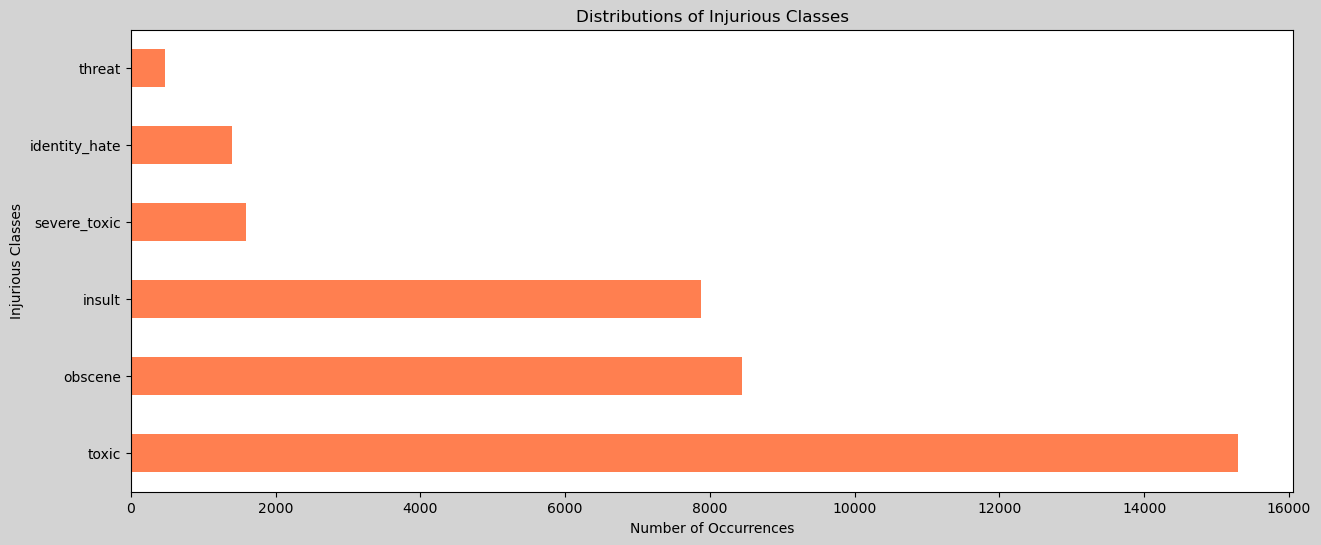

In [16]:
# Plot injurious classes distribution
plt.figure(figsize = (15, 6), facecolor = 'lightgrey')
injurious_classes_counts.plot(kind = 'barh', color = 'coral')
plt.title('Distributions of Injurious Classes')
plt.xlabel('Number of Occurrences')
plt.ylabel('Injurious Classes')
plt.xticks()
plt.show()

From this brief analysis, it can be observed that dangerous comments constitute a small portion of the total. Additionally, the classes related to 'threat,' 'identity_hate,' and 'severe_toxicity' are less represented compared to others, suggesting that the model may predict them with less accuracy.

In [17]:
# Distribution of injurious classes combinations
df_injurious_classes_combinations = df.drop(['comment_text', 'sum_injurious'], axis = 1)
df_injurious_classes_combinations_counts = df_injurious_classes_combinations.groupby(df_injurious_classes_combinations.columns.tolist(), as_index = False).size()
df_injurious_classes_combinations_counts.sort_values(by = 'size', ascending = False, ignore_index = True)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,size
0,0,0,0,0,0,0,143346
1,1,0,0,0,0,0,5666
2,1,0,1,0,1,0,3800
3,1,0,1,0,0,0,1758
4,1,0,0,0,1,0,1215
5,1,1,1,0,1,0,989
6,1,0,1,0,1,1,618
7,0,0,1,0,0,0,317
8,0,0,0,0,1,0,301
9,1,1,1,0,1,1,265



Since there is only one comment available for the last two combinations, in order to proceed with a consistent split between the train and test datasets, these two data points will be manually removed to apply stratification to the target. Given the very large amount of data, it is believed that removing two comments will not be impactful, especially compared to the advantage of being able to homogenize the train and test datasets.

## 2 - Preprocessing

In [18]:
# Preserve original dataset
df_preprocess = df.copy()

### 2.0 - Drop Unique Classes Combinations

For the reasons mentioned above, the two unique observations are removed.

In [19]:
# Drop classes combination [1, 1, 0, 1, 1, 0]
unique_outlier_classes_combination_index = df_preprocess[(df_preprocess['toxic'] == 1) & (df_preprocess['severe_toxic'] == 1) & (df_preprocess['obscene'] == 0) &
                                                         (df_preprocess['threat'] == 1) & (df_preprocess['insult'] == 1) & (df_preprocess['identity_hate'] == 0)].index

df_preprocess.drop(unique_outlier_classes_combination_index, inplace = True)

In [20]:
# Drop classes combination [1, 1, 0, 1, 0, 1]
unique_outlier_classes_combination_index = df_preprocess[(df_preprocess['toxic'] == 1) & (df_preprocess['severe_toxic'] == 1) & (df_preprocess['obscene'] == 0) &
                                                         (df_preprocess['threat'] == 1) & (df_preprocess['insult'] == 0) & (df_preprocess['identity_hate'] == 1)].index

df_preprocess.drop(unique_outlier_classes_combination_index, inplace = True)

In [21]:
# Check that only 2 observations have been removed
df_preprocess['sum_injurious'].value_counts().loc[1:6].sum()

16223

### 2.1 - Text Cleaning

#### Display All Unique Characters

In [22]:
# Show the list of unique characters
show_unique_characters(df_preprocess['comment_text'])

{'ľ', 'ŕ', '撃', 'Ы', '†', '❉', '\uf701', '武', '₤', '̜', 'а', 'リ', 'ð', 'А', 'Қ', 'き', '찜', '┐', '⊥', 'Η', 'Ḍ', 'ш', '話', '市', '↨', 'க', '妈', '聯', 'پ', '❞', '０', '\x94', 'Û', 'į', 'Θ', 'α', '✆', 'Ώ', 'χ', 'ầ', '|', '\x9d', 'ض', '주', 'ظ', '€', '▎', '৳', 'ῷ', '𐌲', 'ხ', '】', '抗', 'ຫ', 'ʔ', 'Ж', 'ゅ', 'ȋ', '若', 'æ', '河', 'A', 'バ', '而', 'Ł', '승', '맛', 'ⲧ', '㎥', '*', '注', 'Л', '8', 'ປ', 'ˈ', 'ት', '☭', 'ќ', '排', '\uf6d9', '容', '\uf736', 'ɺ', '演', '۸', 'વ', '\u202a', 'ṣ', '栗', 'ˉ', '見', '統', '»', 'Ş', '〉', '品', '路', '川', 'Ў', 'ἡ', 'M', '您', 'ǘ', '八', '小', '選', '宕', 'サ', 'ട', 'Ї', '堵', 'S', '≡', '即', '賜', 'ử', '竜', '薬', 'р', '┏', 'ɧ', 'ὧ', '۬', '浦', '大', '\u202f', '😏', 'ប', '̫', '曹', 'E', 'ξ', ' ', '仙', 'ო', '☯', '≤', 'क', 'Ŀ', 'য', '卐', '楊', 'Ť', 'ờ', '列', '君', 'ψ', '笑', 'ᵀ', '’', '京', '✞', '̄', 'ɭ', '神', 'ｋ', 'z', 'ø', '№', 'Ĕ', '番', 'ҝ', 'ỹ', 'Ѕ', '^', 'ந', 'ノ', 'Ĉ', '尻', 'ਸ', '后', '♪', 'Ù', 'Ů', '稿', '‡', 'ে', '捏', 'ﬂ', 'ַ', '亞', 'ட', 'ຣ', 'Ǐ', '☃', '陳', 'Ñ', 'Ã', 'ᵗ', '‽', '或', '\x7f', 'ɞ', 

#### Normalize Text

In [23]:
# Convert to lower case
df_preprocess['comment_text'] = df_preprocess['comment_text'].apply(lambda x: x.lower())
df_preprocess['comment_text'].head()

0    explanation\nwhy the edits made under my usern...
1    d'aww! he matches this background colour i'm s...
2    hey man, i'm really not trying to edit war. it...
3    "\nmore\ni can't make any real suggestions on ...
4    you, sir, are my hero. any chance you remember...
Name: comment_text, dtype: object

#### Replace Newlines and Tabulations

In [24]:
# Regular expression for newline and tab character
regex_newline_tab = r'[\n\t]'

# Replace the special characters with a space
df_preprocess['comment_text'] = df_preprocess['comment_text'].str.replace(regex_newline_tab, ' ', regex = True)
df_preprocess['comment_text'].head()

0    explanation why the edits made under my userna...
1    d'aww! he matches this background colour i'm s...
2    hey man, i'm really not trying to edit war. it...
3    " more i can't make any real suggestions on im...
4    you, sir, are my hero. any chance you remember...
Name: comment_text, dtype: object

#### Remove Unwanted Unicode Characters

In [25]:
# Regular expression to keep alphanumeric characters and spaces and to remove tags, URLs and hyperlinks
regex_unicode = re.compile(r"([^0-9A-Za-z ])|(@\[A-Za-z0-9]+)|(\w+:\/\/\S+)|http.+?")

# Apply regular expression replacing not allowed symbols and strings with a space
df_preprocess['comment_text'] = df_preprocess['comment_text'].str.replace(regex_unicode, ' ', regex = True)
df_preprocess['comment_text'].head()

0    explanation why the edits made under my userna...
1    d aww  he matches this background colour i m s...
2    hey man  i m really not trying to edit war  it...
3      more i can t make any real suggestions on im...
4    you  sir  are my hero  any chance you remember...
Name: comment_text, dtype: object

#### Verify Remaining Characters

In [26]:
# Show the list of unique characters
show_unique_characters(df_preprocess['comment_text'])

{'k', 'n', 'y', 'i', 'g', ' ', 'a', 'w', '2', 's', '9', 'h', 'c', 'j', 'x', 'p', '5', 'l', 'e', 'r', 'v', 'b', 'q', '7', '8', 't', '0', '1', '6', '4', 'o', '3', 'u', 'z', 'm', 'd', 'f'}


#### Remove Stopwords

In [27]:
# Download stopwords from Natural Language Toolkit
nltk.download('stopwords')

# Select stopwords for english language
stopwords_eng = nltk.corpus.stopwords.words('english')

# Show words to be removed
print(stopwords_eng)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tripxer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
# Remove stopwords from the dataset
df_preprocess['comment_text'] = df_preprocess['comment_text'].apply(lambda x: remove_stopwords(x, stopwords = stopwords_eng))
df_preprocess['comment_text'].head()

0    explanation edits made username hardcore metal...
1    aww matches background colour seemingly stuck ...
2    hey man really trying edit war guy constantly ...
3    make real suggestions improvement wondered sec...
4                        sir hero chance remember page
Name: comment_text, dtype: object

#### Lemmatization

In [29]:
# Download lexical database
nltk.download('wordnet')
nltk.download('omw-1.4')

# Istantiate the lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

# Apply lemmatization to the dataset
df_preprocess['comment_text'] = df_preprocess['comment_text'].apply(lambda x: lemmatize_text(x, lemmatizer = lemmatizer))
df_preprocess['comment_text'].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tripxer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Tripxer\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0    explanation edits made username hardcore metal...
1    aww match background colour seemingly stuck th...
2    hey man really trying edit war guy constantly ...
3    make real suggestion improvement wondered sect...
4                        sir hero chance remember page
Name: comment_text, dtype: object

In [30]:
# Store of preprocessed dataset
df_preprocess.to_csv(FOLDER_DATASETS + "dataset_preprocessed.csv", index = False)

### 2.2 - Vocabulary

In [31]:
# Tokenize with the average number of lemmas known by a english speaker 
tokenizer = Tokenizer(num_words = TOKENIZER_WORDS_NUMBER)

In [32]:
# Create a vocabulary from comment
tokenizer.fit_on_texts(df_preprocess['comment_text'])

In [33]:
# Check number of entries
tokenizer.document_count

159569

In [34]:
## Show the 10 most frequent words ##

# Extract first words from dictionary already ordered by frequency
top_words = [tokenizer.index_word[i] for i in range(1, 11)]

# Extract words frequencies
word_counts = tokenizer.word_counts
word_frequencies = [word_counts[word] for word in top_words]

# Create a dataframe to print a tabulated output
df_top_words = pd.DataFrame({'Lemma': top_words, 'Frequency': word_frequencies}, index = range(1, 11))
print(df_top_words)

        Lemma  Frequency
1     article      74195
2        page      57112
3   wikipedia      46131
4        talk      37558
5         one      30727
6      please      29797
7       would      29322
8        like      28432
9         see      21804
10     source      21753


In [35]:
# Vocabulary size
vocabulary_size = len(tokenizer.word_index) + 1 # 1 character reserved for padding
print(f"Vocabulary size: {vocabulary_size}")

Vocabulary size: 163332


### 2.3 - Sequences

In [36]:
# Create sequences exploiting tokenized words
sequences = tokenizer.texts_to_sequences(df_preprocess['comment_text'])

In [37]:
# Show the first encoded comments...
for sequence in sequences[:5]:
    print(sequence)

[472, 55, 57, 552, 4101, 10210, 655, 227, 117, 5817, 2288, 2638, 47, 1034, 10715, 2513, 6, 143, 179, 4, 2, 68, 3054, 2745, 4166, 2049, 867]
[14503, 993, 420, 2656, 4102, 2435, 25, 4, 679, 2390, 839, 471, 7684, 101]
[291, 297, 61, 152, 16, 166, 238, 2045, 371, 383, 32, 480, 55, 251, 4, 2, 122, 278, 2152, 611, 348]
[19, 232, 592, 1274, 5438, 40, 2072, 391, 3066, 374, 2712, 11, 65, 20, 24, 11759, 1294, 989, 2066, 242, 989, 218, 391, 5, 197, 44, 2198, 2152, 169, 65, 30, 6, 105, 13, 422, 4993, 1, 216, 504, 20, 1760, 2026, 947, 305, 383, 414, 3241, 3, 29, 1, 819, 4320]
[1480, 2446, 817, 456, 2]


In [38]:
# ...and the decoded ones
texts = tokenizer.sequences_to_texts(sequences)
for text in texts[:5]:
    print(text)

explanation edits made username hardcore metallica fan reverted vandalism closure gas voted new york doll fac please remove template talk page since retired 89 205 38 27
aww match background colour seemingly stuck thanks talk 21 51 january 11 2016 utc
hey man really trying edit war guy constantly removing relevant information talking edits instead talk page seems care formatting actual info
make real suggestion improvement wondered section statistic later subsection type accident think reference may need tidying exact format ie date format etc later one else first preference formatting style reference want please let know appears backlog article review guess may delay reviewer turn listed relevant form eg wikipedia good article nomination transport
sir hero chance remember page


#### Sequences Padding

In [39]:
# Lenght of longest sequence
sequence_maximum_length = len(max(sequences, key = len))
sequence_maximum_length

1250

In [40]:
# Padding sequences shorter than longest one prepending a 0
padded_sequences = pad_sequences(sequences, maxlen = sequence_maximum_length)

## 3 - Modeling

As a reference baseline, a simple logistic regression model is trained by setting class balancing. Then different types of recurrent neural networks will be trained and their performances will be compared afterward.

#### Features and Target Selection

In [41]:
# Select features and target
X = padded_sequences
Y = df_preprocess.drop(['comment_text', 'sum_injurious'], axis = 1).values

In [42]:
# Number of classes
classes_number = Y.shape[1]

# Classes names
classes_names = df_preprocess.drop(['comment_text', 'sum_injurious'], axis = 1).columns

In [43]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = TEST_SIZE_RATIO, stratify = Y, random_state = RANDOM_SEED)

In [44]:
# Check train and test sizes
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((127655, 1250), (127655, 6), (31914, 1250), (31914, 6))

### 3.0 - Baseline Logistic Regressor Model


Model LogRegr already trained is loaded

Model prediction:


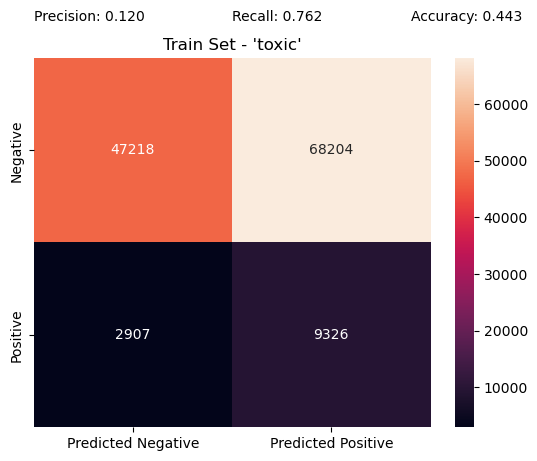

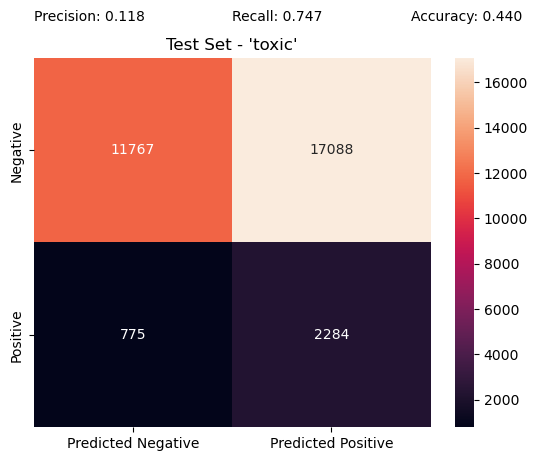

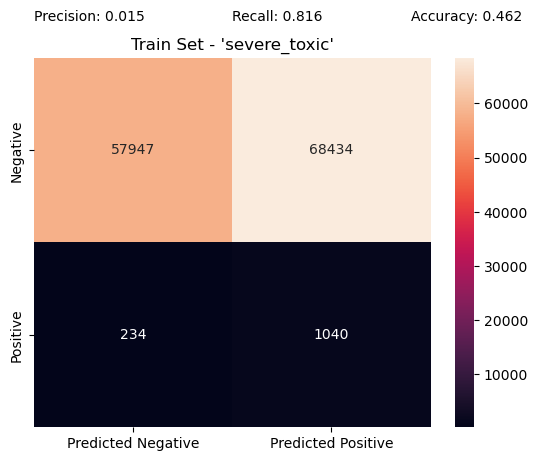

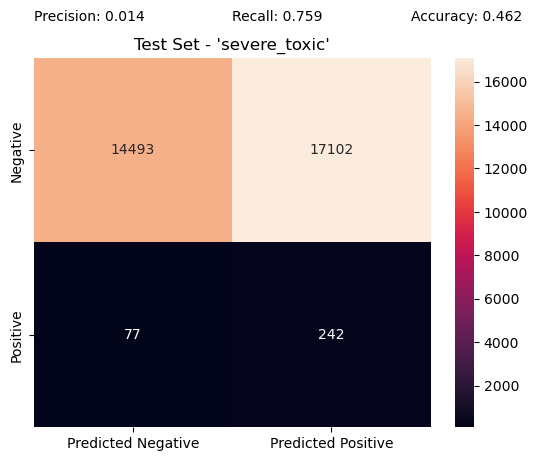

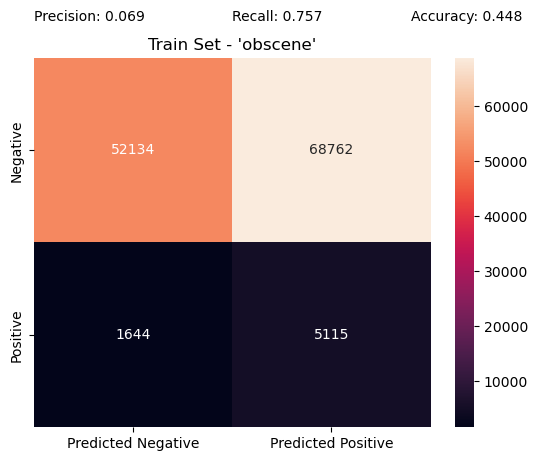

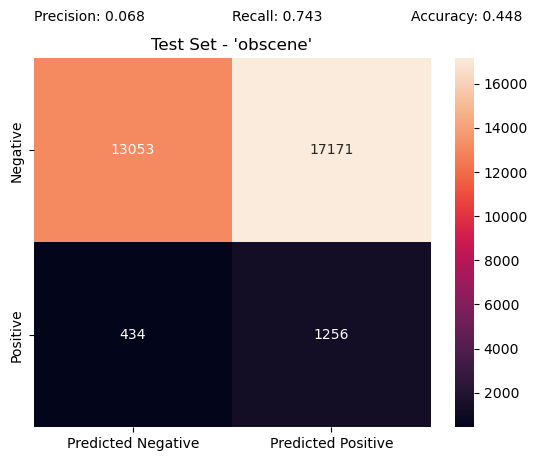

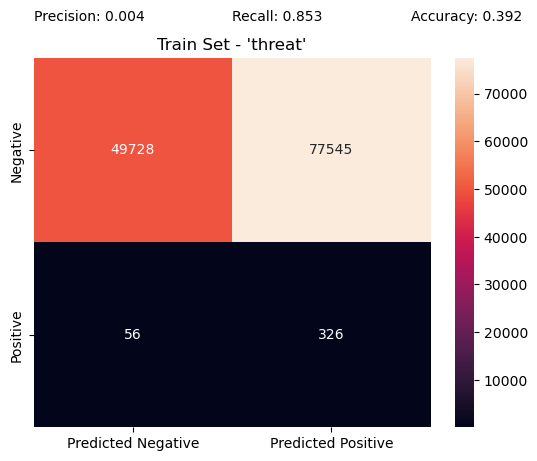

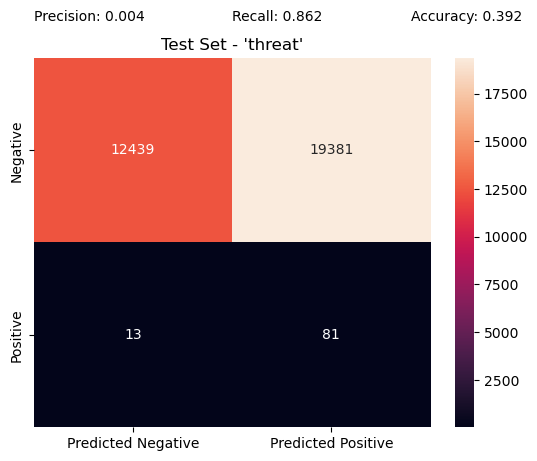

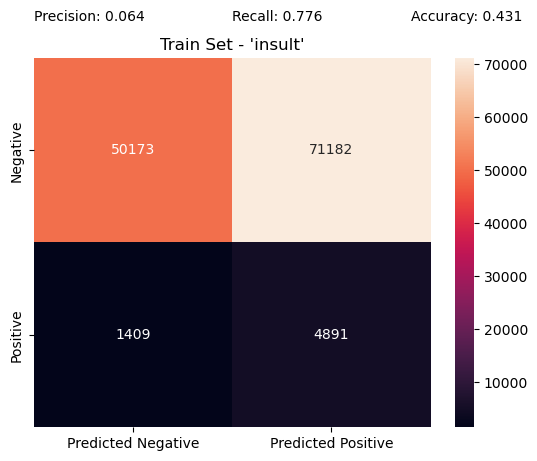

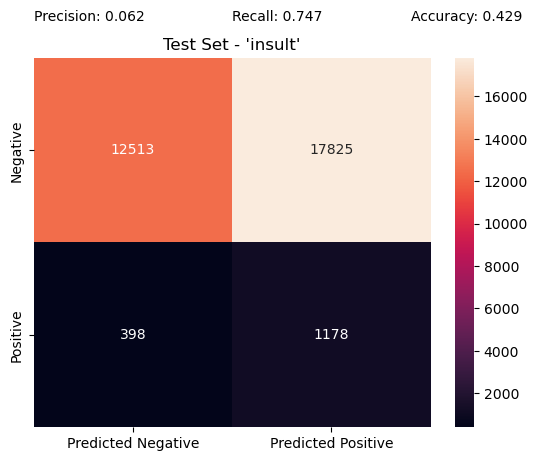

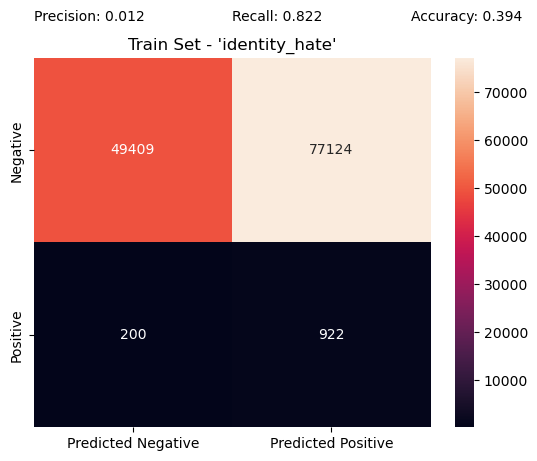

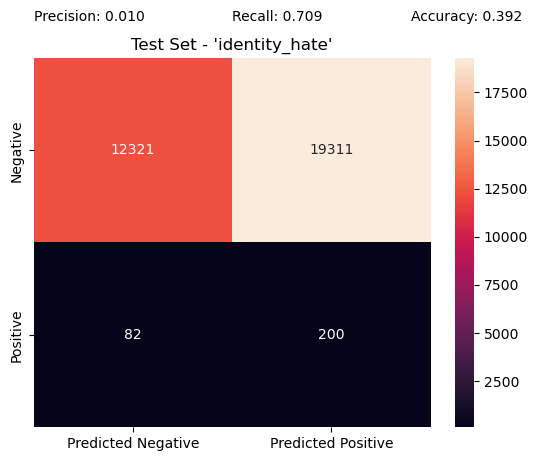

In [45]:
model_lr, metrics_lr = generate_logistic_regressor(# Model info
                                       model_name = "LogRegr",
                                       targets_number = classes_number,
                                       targets_names = classes_names,
    
                                       # Model data
                                       X_train = X_train, Y_train = Y_train,
                                       X_test = X_test, Y_test = Y_test,
    
                                       # LogisticRegression hyperparameters
                                       class_weight = 'balanced',
                                       max_iter = 500,

                                       # Random seed for reproducibility
                                       random_state = RANDOM_SEED,
    
                                       # Metrics display option
                                       show_metrics = False,
                                       show_confusion_matrix = True,
                                       metrics_report = True,
    
                                       # Model loading flag
                                       load_trained_model = LOAD_TRAINED_MODELS)

### 3.1 - Simple Recurrent Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 128)         20906496  
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 20919238 (79.80 MB)
Trainable params: 20919238 (79.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Model RNN already trained is loaded

Model prediction:
998/998 [==============================] - 37s 37ms/step


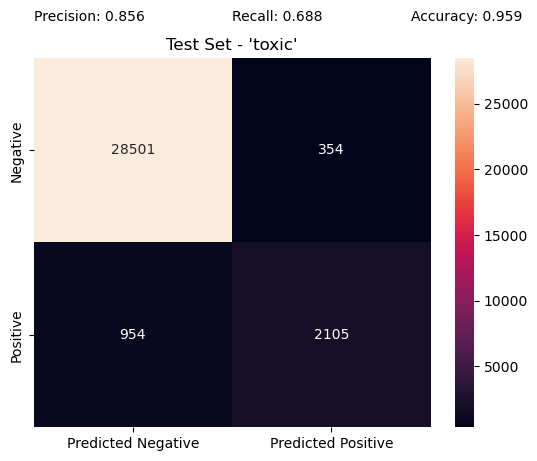

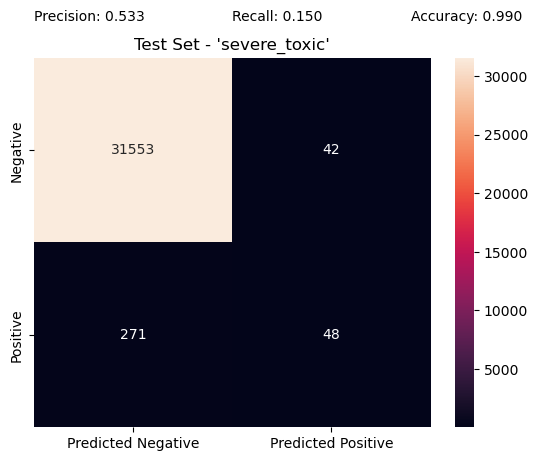

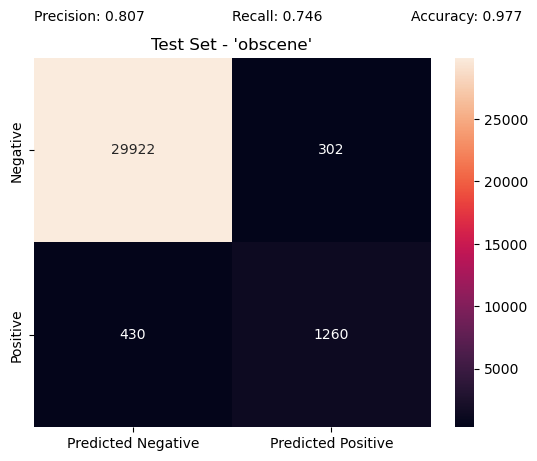

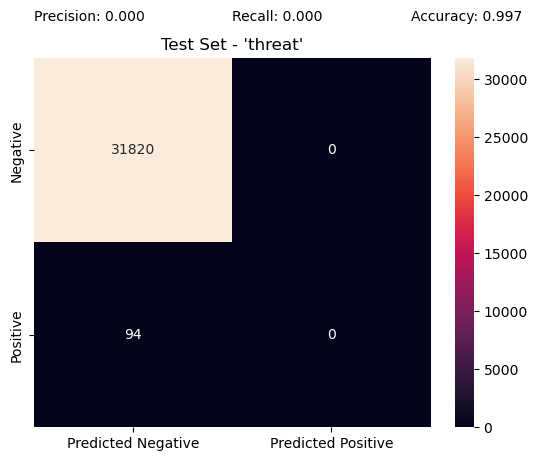

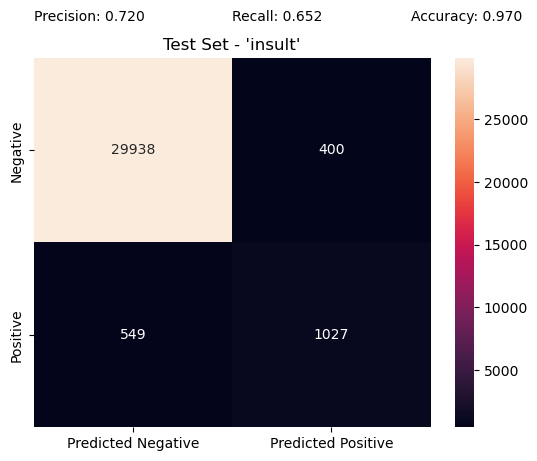

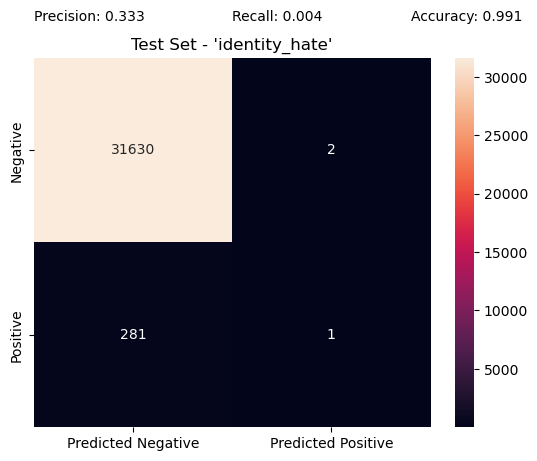

In [46]:
model_rnn, history_rnn, metrics_rnn = train_and_evaluate_rnn_model(
                                      # Model info
                                      model_name = "RNN",
                                      model_type = 'Simple',
                                      targets_number = classes_number,
                                      targets_names = classes_names,
        
                                      # Model data
                                      X_train = X_train, Y_train = Y_train,
                                      X_test = X_test, Y_test = Y_test,
        
                                      # Layer sizes
                                      input_dim = vocabulary_size,
                                      input_length = sequence_maximum_length,
                                      dense_output_dim = classes_number,
            
                                      # Training hyperparameters
                                      epochs = 100,
                                      batch_size = 1024,
        
                                      # Metrics display option
                                      show_metrics = False,
                                      show_confusion_matrix = True,
                                      metrics_report = True,
        
                                      # Model loading flag
                                      load_trained_model = LOAD_TRAINED_MODELS)

### 3.2 - Long Short-Term Memory

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 128)         20906496  
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 20956294 (79.94 MB)
Trainable params: 20956294 (79.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Model LSTM already trained is loaded

Model prediction:
998/998 [==============================] - 99s 100ms/step


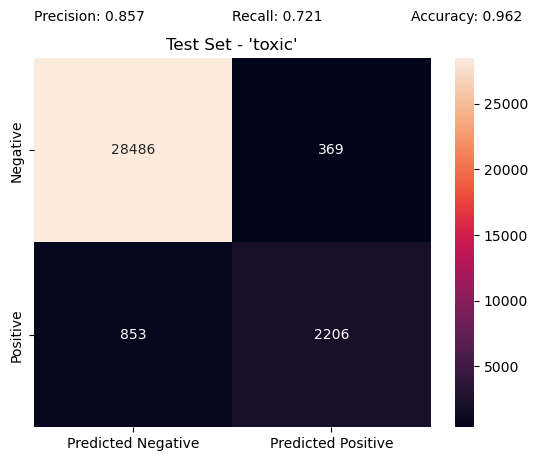

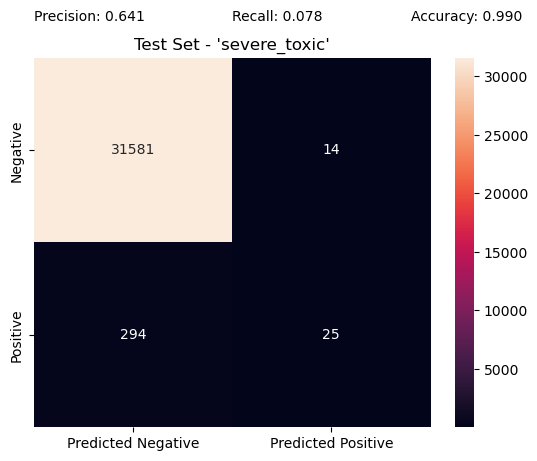

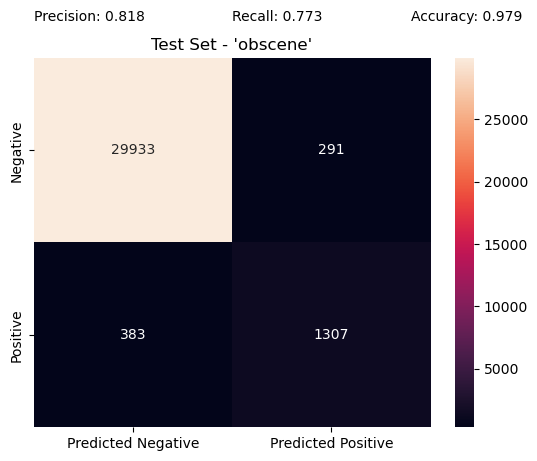

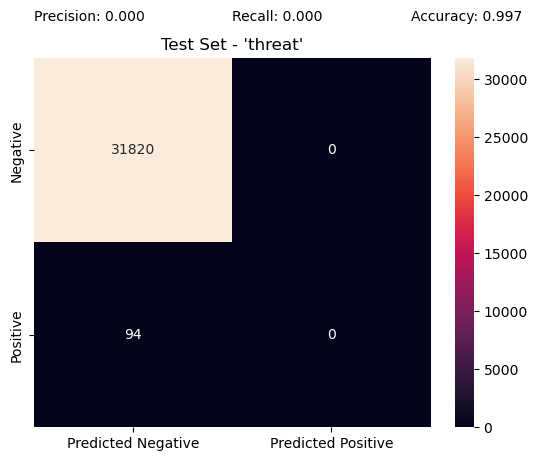

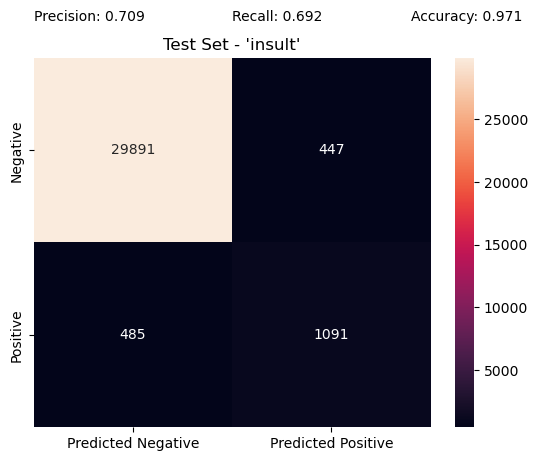

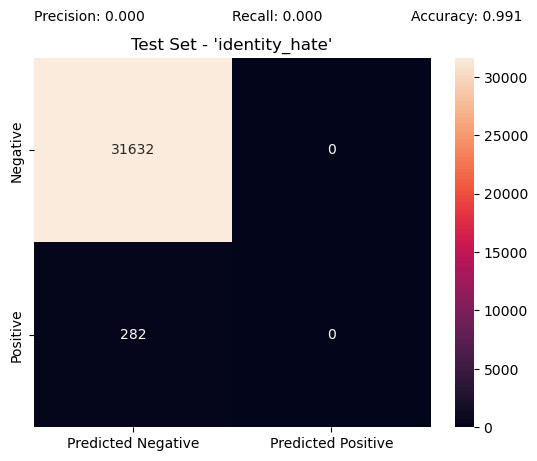

In [47]:
model_lstm, history_lstm, metrics_lstm = train_and_evaluate_rnn_model(
                                          # Model info
                                          model_name = "LSTM",
                                          model_type = 'LSTM',
                                          targets_number = classes_number,
                                          targets_names = classes_names,
                
                                          # Model data
                                          X_train = X_train, Y_train = Y_train,
                                          X_test = X_test, Y_test = Y_test,
                
                                          # Layer sizes
                                          input_dim = vocabulary_size,
                                          input_length = sequence_maximum_length,
                                          dense_output_dim = classes_number,
                
                                          # Training hyperparameters
                                          epochs = 100,
                                          batch_size = 1024,
                
                                          # Metrics display option
                                          show_metrics = False,
                                          show_confusion_matrix = True,
                                          metrics_report = True,
                
                                          # Model loading flag
                                          load_trained_model = LOAD_TRAINED_MODELS)

### 3.3 - Gate Recurrent Unit

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 128)         20906496  
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 20944134 (79.90 MB)
Trainable params: 20944134 (79.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Model GRU already trained is loaded

Model prediction:
998/998 [==============================] - 74s 74ms/step


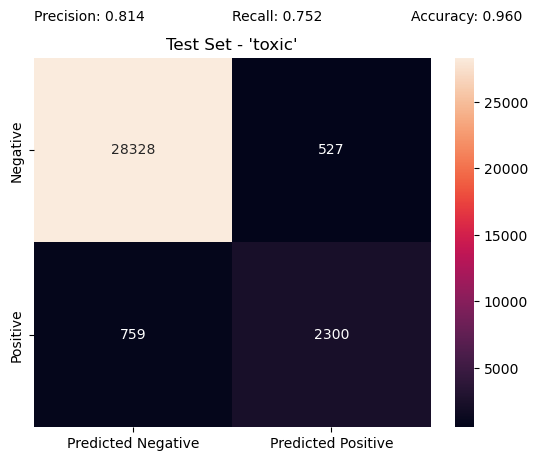

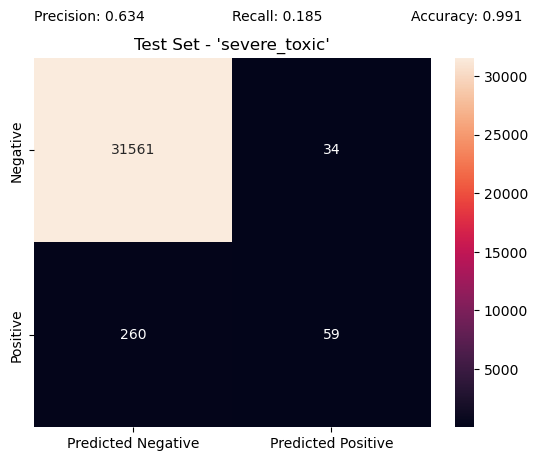

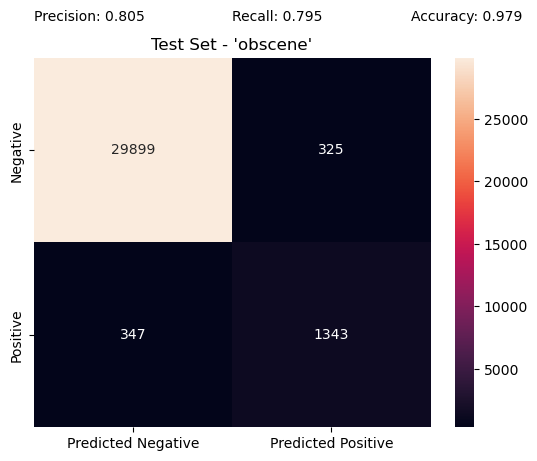

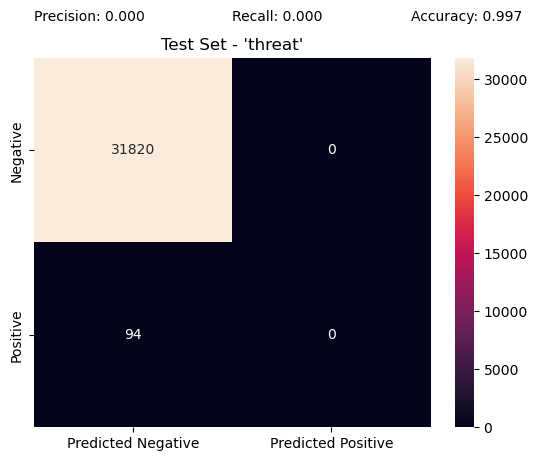

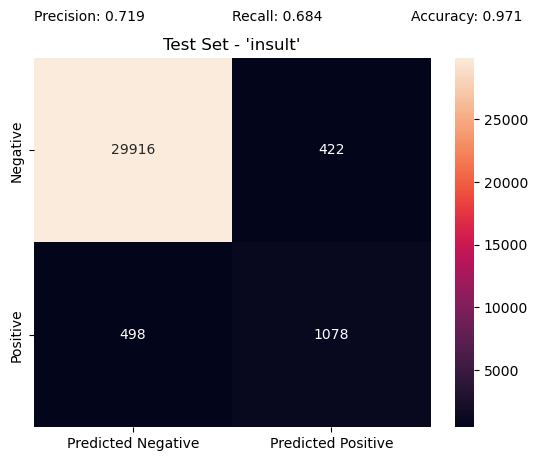

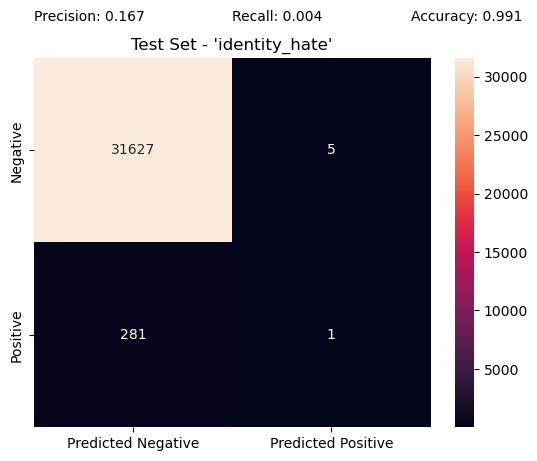

In [48]:
model_gru, history_gru, metrics_gru = train_and_evaluate_rnn_model(
                                      # Model info
                                      model_name = "GRU",
                                      model_type = 'GRU',
                                      targets_number = classes_number,
                                      targets_names = classes_names,
        
                                      # Model data
                                      X_train = X_train, Y_train = Y_train,
                                      X_test = X_test, Y_test = Y_test,
        
                                      # Layer sizes
                                      input_dim = vocabulary_size,
                                      input_length = sequence_maximum_length,
                                      dense_output_dim = classes_number,
            
                                      # Training hyperparameters
                                      epochs = 100,
                                      batch_size = 1024,
        
                                      # Metrics display option
                                      show_metrics = False,
                                      show_confusion_matrix = True,
                                      metrics_report = True,
        
                                      # Model loading flag
                                      load_trained_model = LOAD_TRAINED_MODELS)

### 3.4 - Bidirectional LSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 128)         20906496  
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 21006086 (80.13 MB)
Trainable params: 21006086 (80.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Model BiLSTM already trained is loaded

Model prediction:
998/998 [==============================] - 120s 120ms/step


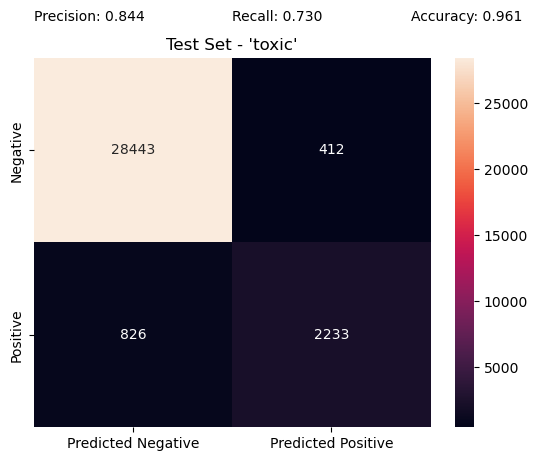

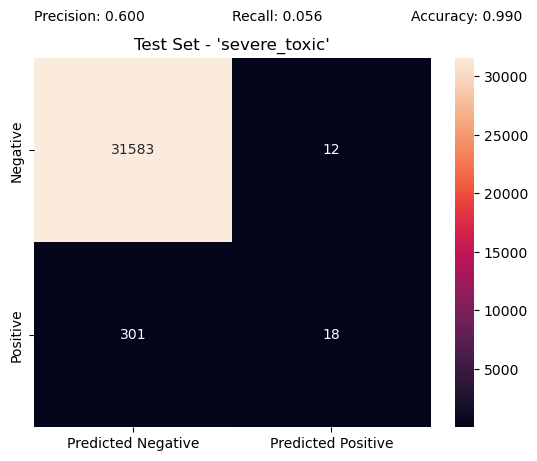

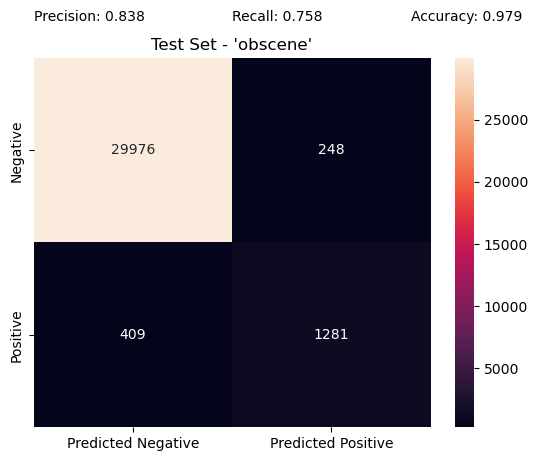

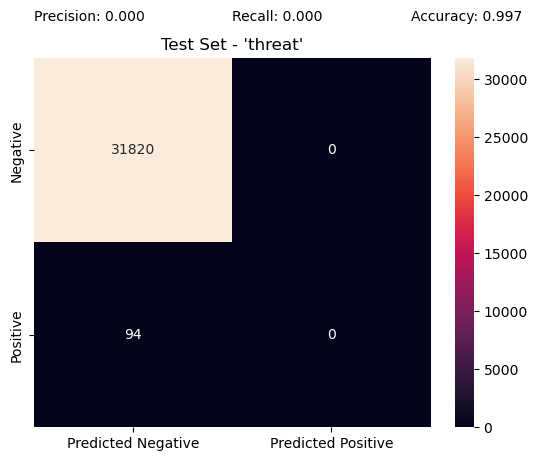

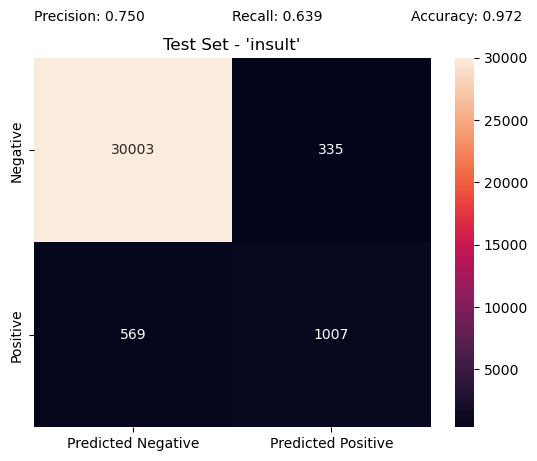

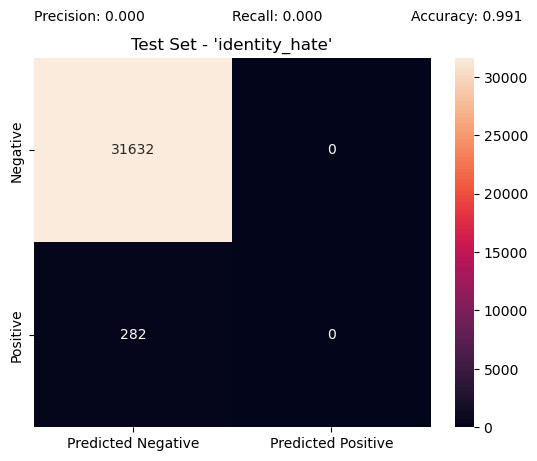

In [49]:
model_bilstm, history_bilstm, metrics_bilstm = train_and_evaluate_rnn_model(
                                                  # Model info
                                                  model_name = "BiLSTM",
                                                  model_type = 'Bidirectional',
                                                  targets_number = classes_number,
                                                  targets_names = classes_names,
                    
                                                  # Model data
                                                  X_train = X_train, Y_train = Y_train,
                                                  X_test = X_test, Y_test = Y_test,
                    
                                                  # Layer sizes
                                                  input_dim = vocabulary_size,
                                                  input_length = sequence_maximum_length,
                                                  dense_output_dim = classes_number,
                        
                                                  # Training hyperparameters
                                                  epochs = 100,
                                                  batch_size = 1024,
                    
                                                  # Metrics display option
                                                  show_metrics = False,
                                                  show_confusion_matrix = True,
                                                  metrics_report = True,
                    
                                                  # Model loading flag
                                                  load_trained_model = LOAD_TRAINED_MODELS)

## 4 - Model Selection

Since the goal is to generally identify an offensive comment, the metrics of each model will be synthesized by taking a weighted average based on the distribution of injurious classes, accounting for the fact that the classes are weighted proportionally. As initially hypothesized, less represented classes indeed resulted in less accurate predictions with many false negatives.

In [50]:
# Show metrics for each injurious class
round(metrics_lr, 2)

,target,precision,recall,accuracy,f1
0,toxic,0.12,0.76,0.44,0.21
1,severe_toxic,0.01,0.82,0.46,0.03
2,obscene,0.07,0.76,0.45,0.13
3,threat,0.00,0.85,0.39,0.01
4,insult,0.06,0.78,0.43,0.12
5,identity_hate,0.01,0.82,0.39,0.02


In [51]:
# Use injurious classes counts to evaluate weighted average metrics
injurious_classes_counts

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

In [52]:
# Metrics list
metrics_list = list(metrics_lr.columns[1:])
metrics_list

['precision', 'recall', 'accuracy', 'f1']

In [53]:
# Classes list
injurious_classes_list = list(df_injurious_classes_combinations.columns)
injurious_classes_list

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

#### Weighted Averaging

In [54]:
def evaluate_average_metrics(models_metrics, models_names, metrics_list, injurious_classes_list, injurious_classes_counts):

    # Cycle all models metrics
    for model_index, metrics in enumerate(models_metrics):

        # Initialize average metrics list
        average_metrics = ["injurious"]
    
        # Evaluate each metric
        for metric_name in metrics_list:
        
            # Initialize weighted metrics sum
            weighted_metrics = 0
        
            # Calculate and sum weighted metrics
            for injurious_index in range(len(injurious_classes_list)):
                weighted_metrics += metrics[metric_name].loc[injurious_index]*injurious_classes_counts[injurious_index]
        
            # Average weighted metric
            average_metric = weighted_metrics/injurious_classes_counts.sum()
            average_metrics.append(average_metric)
        
        # Convert average metrics list in a DataFrame
        average_metrics_row = pd.DataFrame([average_metrics], columns = metrics.columns)
        
        # Concatenate with model metrics DataFrame
        models_metrics[model_index] = pd.concat([metrics, average_metrics_row], ignore_index = True)
    
    # Initialize average metrics list for all model
    models_average_metrics = []
    
    # Cycle each model and related metrics
    for model_name, metrics in zip(models_names, models_metrics):
        
        # Extract metrics excluding target class column
        average_metrics_row = [model_name] + metrics.iloc[-1, 1:].tolist()
        
        # Append model metrics
        models_average_metrics.append(average_metrics_row)
    
    # Create models metrics dataframe
    df_average_metrics = pd.DataFrame(models_average_metrics, columns = ["model"] + metrics.columns[1:].tolist())

    return df_average_metrics

In [55]:
# List with all models metrics
models_metrics = [metrics_lr, metrics_rnn, metrics_lstm, metrics_gru, metrics_bilstm]

# Models names
models_names = ["LogRegr", "RNN", "LSTM", "GRU", "BiLSTM"]

# Evaluate average metrics for all models
df_average_metrics = evaluate_average_metrics(models_metrics, models_names, metrics_list, injurious_classes_list, injurious_classes_counts)

# Show final average metrics for all models
round(df_average_metrics, 3)

,model,precision,recall,accuracy,f1
0,LogRegr,0.074,0.780,0.445,0.132
1,RNN,0.716,0.530,0.973,0.590
2,LSTM,0.740,0.534,0.975,0.581
3,GRU,0.719,0.578,0.974,0.617
4,BiLSTM,0.730,0.527,0.975,0.572


Overall the neural network models show comparable performance, but the GRU model seems to have a better balance between precision and recall, with a slightly higher overall F1 score.

## 5 - Training History

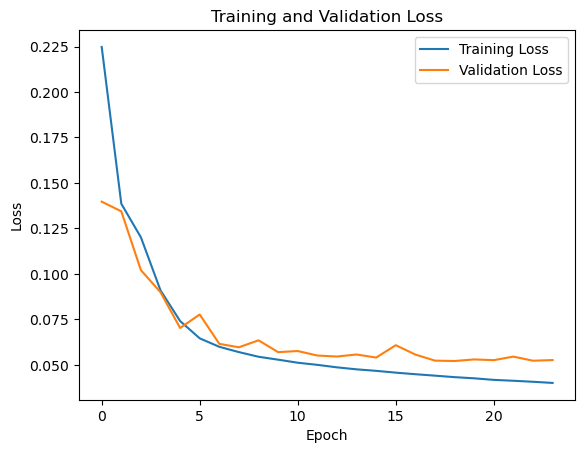

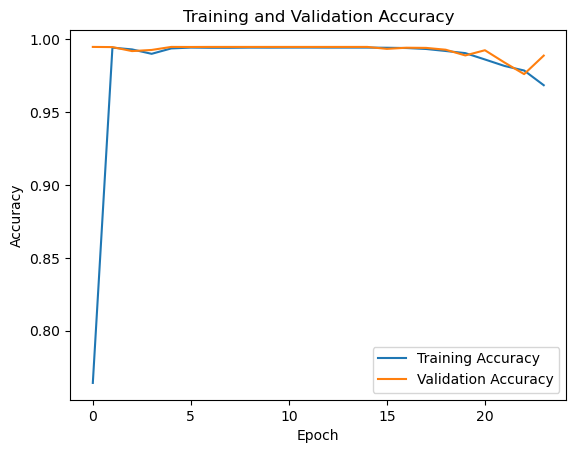

In [56]:
def plot_training_history(history):
    
    # Loss plot
    plt.plot(history['loss'], label = 'Training Loss')
    plt.plot(history['val_loss'], label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Accuracy plot
    plt.plot(history['accuracy'], label = 'Training Accuracy')
    plt.plot(history['val_accuracy'], label = 'Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Plot training history for loss and accuracy
plot_training_history(history_gru)

Evaluating the training history, it's evident that accuracy reaches its peak already in the early epochs before start declining around epoch 17. On the other hand, log loss decreases rapidly until epoch 5 and then decreases more slowly in subsequent epochs. Therefore, an attempt is made to further fine-tune the GRU model by retraining it until epoch 14, where the best combination of accuracy and log loss is achieved.

## 6 - Best Epoch Training

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 128)         20906496  
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 20944134 (79.90 MB)
Trainable params: 20944134 (79.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



Model GRU_Best already trained is loaded

Model prediction:
998/998 [==============================] - 74s 74ms/step


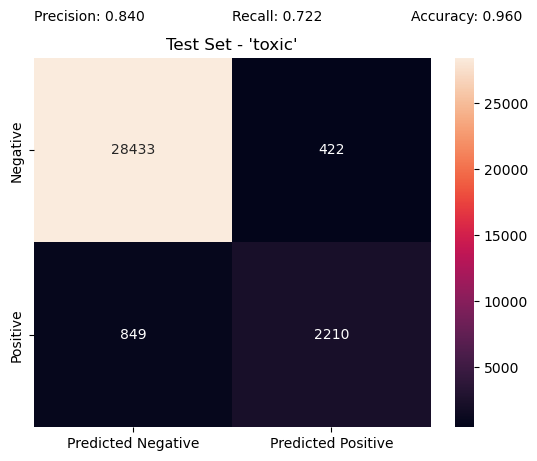

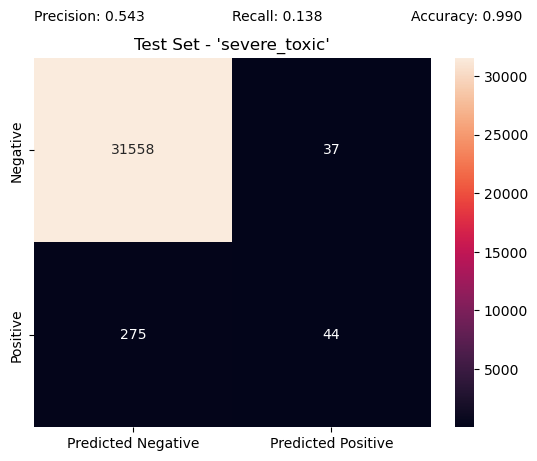

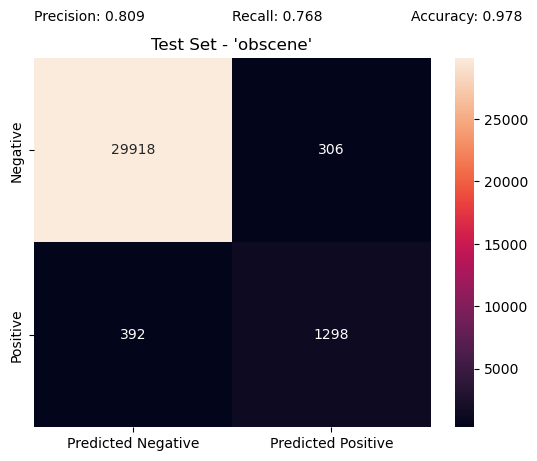

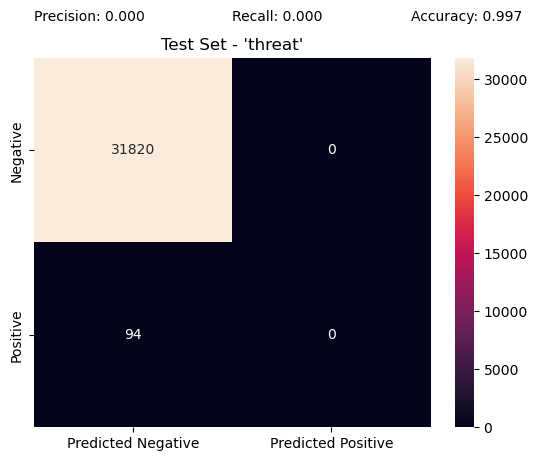

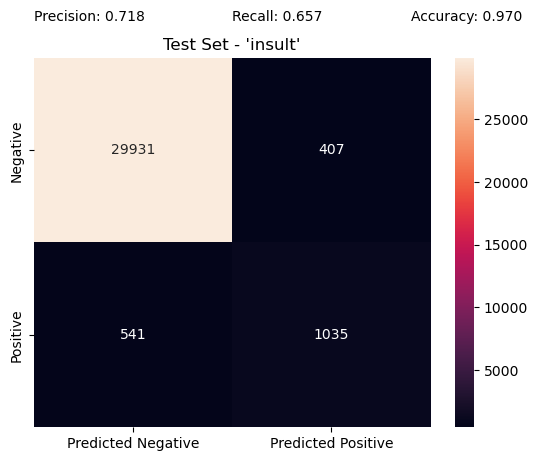

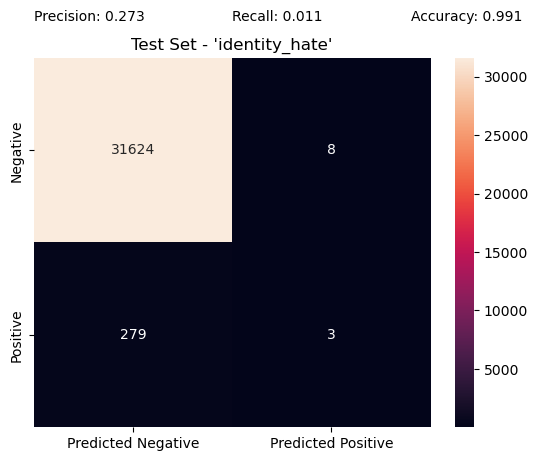

In [57]:
model_gru_best, history_gru_best, metrics_gru_best = train_and_evaluate_rnn_model(
                                                      # Model info
                                                      model_name = "GRU_Best",
                                                      model_type = 'GRU',
                                                      targets_number = classes_number,
                                                      targets_names = classes_names,
                        
                                                      # Model data
                                                      X_train = X_train, Y_train = Y_train,
                                                      X_test = X_test, Y_test = Y_test,
                        
                                                      # Layer sizes
                                                      input_dim = vocabulary_size,
                                                      input_length = sequence_maximum_length,
                                                      dense_output_dim = classes_number,
                            
                                                      # Training hyperparameters
                                                      epochs = 14,
                                                      batch_size = 1024,
                        
                                                      # Metrics display option
                                                      show_metrics = False,
                                                      show_confusion_matrix = True,
                                                      metrics_report = True,
                        
                                                      # Model loading flag
                                                      load_trained_model = LOAD_TRAINED_MODELS)

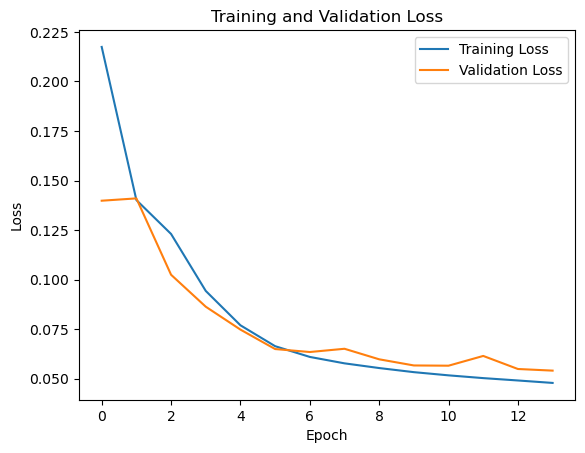

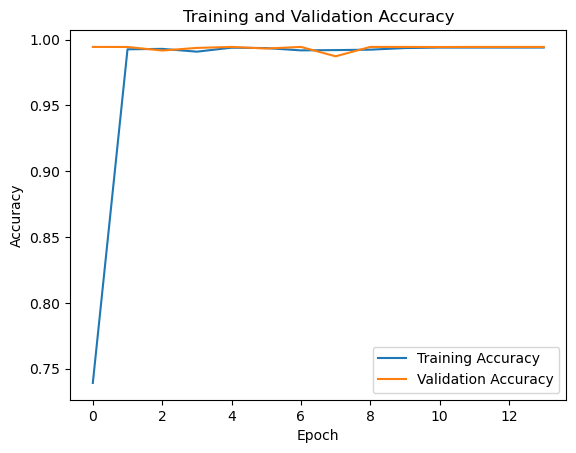

In [58]:
# Plot training history for loss and accuracy
plot_training_history(history_gru_best)

#### GRU Model Comparison

In [59]:
# List with all models metrics
models_metrics = [metrics_gru, metrics_gru_best]

# Models names
models_names = ["GRU", "GRU_Best"]

# Evaluate average metrics for all models
df_average_metrics = evaluate_average_metrics(models_metrics, models_names, metrics_list, injurious_classes_list, injurious_classes_counts)

# Show final average metrics for all models
round(df_average_metrics, 3)

,model,precision,recall,accuracy,f1
0,GRU,0.719,0.578,0.974,0.617
1,GRU_Best,0.711,0.547,0.974,0.596


Despite the attempt, the first GRU model still performs better, suggesting that further precautions are needed to more consistently evaluate the model performance during training.

## 6 - Prediction

Now the preprocessing of text and the model prediction are consolidated into a single function so evaluate compactly the model predictions for further test comments. The function needs as input the model to use, the comment to predict, the vocabulary tokenizer, the maximum padding length and the threshold for the sigmoid output.

In [60]:
def preprocess_and_predict_comment(model, comment, tokenizer, maxlen, threshold):

    # Normalize text with lower case
    comment = comment.lower()

    # Replace newline and tabulation characters with spaces
    comment = re.sub(r"[\n\t]", ' ', comment)

    # Remove unicode characters
    comment = re.sub(r"([^0-9A-Za-z ])|(@\[A-Za-z0-9]+)|(\w+:\/\/\S+)|http.+?", '', comment)

    # Remove english stopwords
    comment = remove_stopwords(comment, stopwords = nltk.corpus.stopwords.words('english'))

    # Lemmatization
    comment = lemmatize_text(comment, lemmatizer = nltk.stem.WordNetLemmatizer())

    # Show preprocessed comment
    print(f"Preprocessed comment:\n# {comment} #\n")

    # Convert text to tokenized sequence
    sequence = tokenizer.texts_to_sequences([comment])
 
    # Sequence padding
    padded_sequence = pad_sequences(sequence, maxlen = maxlen)

    # Prediction
    predicted_classes = model.predict(padded_sequence.reshape(1, -1)) > threshold
    
    return predicted_classes[0]

In [61]:
def show_prediction_result(predicted_classes, injurious_classes):
    
    print("\nPrediction:")
    for predicted_class, class_name in zip(predicted_classes, injurious_classes):
        print(f"* {class_name}: {predicted_class}")

In [62]:
# Example comments
positive_comment = "That's a fantastic photo! 😍 The colors are so vivid and the composition is perfect.\nCongratulations on the shot! 💯"
negative_comment = "What a horrible photo! 😒 Who gave you permission to post this garbage? Do us all a favor and stop spamming our feed with your ugly face. 🙄 \t#fail"

In [63]:
# Preprocess the comment
predicted_classes = preprocess_and_predict_comment(model_gru, positive_comment, tokenizer, sequence_maximum_length, SIGMOID_PREDICTION_THRESHOLD)

# Show prediction
show_prediction_result(predicted_classes, injurious_classes_list)

Preprocessed comment:
# thats fantastic photo color vivid composition perfect congratulation shot #

1/1 [==============================] - 0s 123ms/step

Prediction:
* toxic: False
* severe_toxic: False
* obscene: False
* threat: False
* insult: False
* identity_hate: False


In [64]:
# Preprocess the comment
predicted_classes = preprocess_and_predict_comment(model_gru, negative_comment, tokenizer, sequence_maximum_length, SIGMOID_PREDICTION_THRESHOLD)

# Show prediction
show_prediction_result(predicted_classes, injurious_classes_list)

Preprocessed comment:
# horrible photo gave permission post garbage u favor stop spamming feed ugly face fail #

1/1 [==============================] - 0s 45ms/step

Prediction:
* toxic: True
* severe_toxic: False
* obscene: True
* threat: False
* insult: True
* identity_hate: False


## 7 - Conclusion

Overall the developed model has acceptable performance for an initial approach to comment filtering. It is observed for all tested neural networks, that generally the recall is lower than the accuracy, indicating the presence of many false negatives, so many offensive comments not detected. This is particularly evident for less represented classes like 'threat', where models completely fail to detect positive cases.

Possible enhancements for the model could include:
* Oversampling less represented offensive comment cases during preprocessing to increase their weight in model training.
* Exploring new neural network structures and importing solutions tailored for semantic analysis of sentences.
* Fine-tuning performance based on the target environment of the model. For instance, it might be necessary to be very strict in recognizing all negative comments in a more absolute way (strong censorship), even at the expense of increasing false positives.